In [29]:
import numpy as np
import pandas as pd
from tensorflow import keras
import seaborn as sns
import matplotlib.pyplot as plt
import string
import re
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from collections import Counter, defaultdict
from bs4 import BeautifulSoup
import warnings
warnings.simplefilter('ignore')

In [30]:
df = pd.read_csv('reviews.csv')
df.sample(5)

,Id,Review,Label
62176,62176,It was very amazing course which provide me wi...,5
14850,14850,a brief and yet organized and good resource fo...,4
43533,43533,Thanks for so great and useful course. I was s...,5
55940,55940,Thanks a lot Sir. Not only did this course mad...,4
62044,62044,We need less lectures and more application bas...,3


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107018 entries, 0 to 107017
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Id      107018 non-null  int64 
 1   Review  107018 non-null  object
 2   Label   107018 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 2.4+ MB


In [32]:
df.Label.value_counts()

5    79173
4    18054
3     5071
1     2469
2     2251
Name: Label, dtype: int64

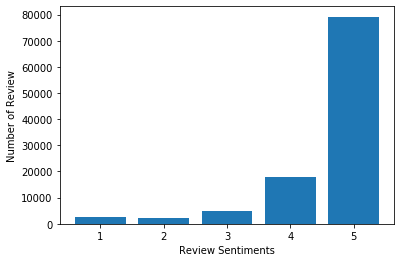

In [33]:
Label_count = df.groupby('Label').count()
plt.bar(Label_count.index.values, Label_count['Review'])
plt.xlabel('Review Sentiments')
plt.ylabel('Number of Review')
plt.show()

In [34]:
print(df.iloc[5]['Review'], 'Label - ', df.iloc[5]['Label'])
print('\n')
print(df.iloc[15]['Review'], 'Label - ', df.iloc[15]['Label'])

Great course - I recommend it for all, especially IT and Business Managers! Label -  5


Program demystifies the evolving world of CIOs in a typical global corporation.Coverage being introductory familiarizes participants nicely through some of the nuances & emerging trends.When I took the course participant numbers was fewer, so feedback was quite delayed. So one should plan to be patient to get their peer reviews.Based on peer reviews i sensed much variations in their expectations.Few sections are in French with Subtitles.Subtitle quality requires audit/review. Label -  4


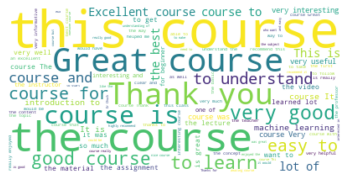

In [35]:
text = " ".join(review for review in df.Review)

wordcloud = WordCloud(max_font_size=80,max_words=100,background_color='white',stopwords=stopwords.words('english')).generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show();

In [36]:
class Tokenizer:
    def clean(self, text):
        no_html = BeautifulSoup(text).get_text()
        clean = re.sub('[^a-z\s]+', ' ', no_html, flags=re.IGNORECASE)
        return re.sub('\s+',' ', clean)
    
    def tokenize(self, text):
        clean = self.clean(text).lower()
        stopwords_en = stopwords.words('english')
        return [w for w in re.split('\W+', clean) if not w in stopwords_en]

In [37]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

xt = Tokenizer().tokenize(text)
y = df['Label']

In [38]:
xen = le.fit_transform(xt)
xen

array([11936, 14547,  4613, ..., 31226, 30105,     0], dtype=int64)

In [39]:
classes = np.unique(y)

def group_by_class(x, y):
        data = dict()
        for c in classes:
            data[c] = x[np.where(y==c)]
        return data

In [40]:
group_by_class(xen, y)

{1: array([29668, 16091, 11209, ..., 30819, 29655, 16043], dtype=int64),
 2: array([ 7744, 25169,  6091, ..., 19045, 29903, 24722], dtype=int64),
 3: array([ 4613, 16354, 26691, ..., 11107, 25169, 30124], dtype=int64),
 4: array([ 6504, 27427,  1073, ..., 25190,  4613,  2261], dtype=int64),
 5: array([11936, 14547,  4613, ..., 23106, 25005,   832], dtype=int64)}

In [41]:
class MultinomialNavieBayes:
    def __init__(self, classes, tokenizer):
        self.tokenizer = tokenizer
        self.classes = classes
        
    def group_by_class(self, x, y):
        data = dict()
        for c in self.classes:
            data[c] = x[np.where(y==c)]
        return data
    
    def fit(self, x, y):
        self.n_class_items = {}
        self.log_class_prior = {}
        self.word_counts = {}
        self.vocab = set()
        
        n = len(x)
        
        grouped_data = self.group_by_class(x, y)
        
        for c, data in grouped_data.items():
            self.n_class_items[c] = len(data)
            self.log_class_prior[c] = math.log(self.n_class_items[c] / n)
            self.word_counts[c] = defaultdict(lambda: 0)
            
            for text in data:
                counts = Counter(self.tokenizer.tokenize(text))
                for word, count in counts.items():
                    if word not in self.vocab:
                        self.vocab.add(word)
                        
                    self.word_counts[c][word] += count
        return self
    
    def laplace_smoothing(self, word, text_class):
        num = self.word_counts[text_class][word] + 1
        denom = self.n_class_items[text_class] + len(self.vocab)
        return math.log(num / denom)
    
    def prediction(self, x):
        result = []
        for text in x:
            class_score = {c: self.log_class_prior[c] for c in self.classes}
            words = set(self.tokenizer.tokenize(text))
            for word in words:
                if word not in self.vocab: continue
                for c in self.classes:
                    log_w_given_c = self.laplace_smoothing(word, c)
                    class_score[c] += log_w_given_c
                    
            result.append(max(class_score, key=class_score.get))
        return result

In [42]:
x = df['Review'].values
y = df['Label'].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [43]:
MNB = MultinomialNavieBayes(classes=np.unique(y), tokenizer=Tokenizer()).fit(x_train, y_train)

In [44]:
y_obs = MNB.prediction(x_test)

In [45]:
accuracy_score(y_test, y_obs)

0.7443468510558774

In [46]:
print(classification_report(y_test, y_obs))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00       493
           2       0.00      0.00      0.00       484
           3       0.00      0.00      0.00       933
           4       0.40      0.02      0.03      3613
           5       0.75      1.00      0.85     15881

    accuracy                           0.74     21404
   macro avg       0.23      0.20      0.18     21404
weighted avg       0.62      0.74      0.64     21404



In [47]:
cnf_matrix = confusion_matrix(y_test, y_obs)
cnf_matrix

array([[    0,     0,     0,    19,   474],
       [    0,     0,     0,    25,   459],
       [    0,     0,     0,    39,   894],
       [    0,     0,     0,    65,  3548],
       [    0,     0,     0,    14, 15867]], dtype=int64)

Text(0.5, 257.44, 'Predicted sentiments')

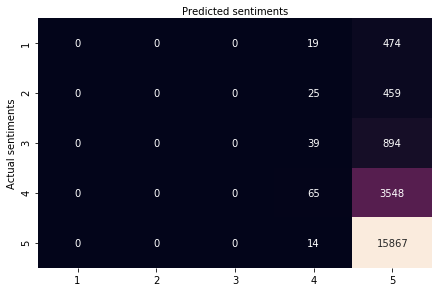

In [48]:
class_names = ['1', '2', '3', '4', '5']
fig, ax = plt.subplots()

sns.heatmap(pd.DataFrame(cnf_matrix), annot=True,fmt='d', cbar=False,xticklabels=class_names,yticklabels=class_names)
ax.xaxis.set_label_position('top')
plt.tight_layout()
plt.ylabel('Actual sentiments')
plt.xlabel('Predicted sentiments')